# Сегментация объектов с помощью DINO + SAM


В этом блокноте мы познакомимся с современным подходом к **сегментации объектов на изображении** с помощью двух мощных моделей: **Grounding DINO** и **SAM**.

Эта связка позволяет автоматически находить и выделять объекты на изображении **без ручной разметки** и **без предварительного обучения на конкретной задаче** — всё работает "из коробки", благодаря возможностям современных foundation-моделей.

Как они работают вместе?

1. **[Grounding DINO](https://github.com/IDEA-Research/GroundingDINO)** получает на вход изображение и текстовый запрос (например, *cat*, *person*, *car*) и возвращает **bounding boxes** — области изображения, которые с высокой вероятностью соответствуют запрошенному объекту.

2. **[SAM](https://github.com/facebookresearch/segment-anything)** использует эти bounding boxes как подсказки и на их основе строит **маски сегментации**, отделяя найденные объекты от фона на уровне пикселей.


В этом блокноте мы загрузим тестовое изображение и на практике посмотрим, как работает связка Grounding DINO + SAM. Мы разберём, как с её помощью находить и сегментировать объекты, а также рассмотрим различные варианты промтов для модели и визуализируем полученные результаты.



# Подготовка окружения и загрузка моделей

Сначала мы клонируем репозиторий Grounding DINO, устанавливаем необходимые библиотеки и подгружаем компоненты моделей.

## Импорты необходимых библиотек

In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!pip install -q segment-anything
%cd "/content/GroundingDINO"
!pip install -q -e .
!pip install -q transformers accelerate scipy safetensors

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 463 (delta 175), reused 136 (delta 136), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 835.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import torch
from PIL import Image
import supervision as sv
import matplotlib.pyplot as plt
import cv2

# Grounding DINO
from huggingface_hub import hf_hub_download
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

# segment anything
from segment_anything import build_sam, SamPredictor

## Загрузка модели Grounding DINO

Напишем функцию для загрузки Grounding DINO с Hugging Face. Она скачивает веса и конфиг, и возвращает готовую к работе модель.

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [ ]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


## Загрузка модели SAM

Теперь загружаем модель SAM, которая будет строить маски сегментации на основе найденных bounding boxes.

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-04-21 06:06:05--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.33, 3.171.22.68, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  30.0MB/s    in 18s     

2025-04-21 06:06:23 (140 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

## Загрузка тестового изображения

In [1]:
!wget 'https://ml.gan4x4.ru/wb/cv/images/desktop_example.jpg'
local_image_path = '/content/GroundingDINO/desktop_example.jpg'

--2025-05-07 16:14:19--  https://ml.gan4x4.ru/wb/cv/images/desktop_example.jpg
Resolving ml.gan4x4.ru (ml.gan4x4.ru)... 212.24.105.216
Connecting to ml.gan4x4.ru (ml.gan4x4.ru)|212.24.105.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111261 (109K) [image/jpeg]
Saving to: ‘desktop_example.jpg’

desktop_example.jpg 100%[===================>] 108.65K   231KB/s    in 0.5s    

2025-05-07 16:14:20 (231 KB/s) - ‘desktop_example.jpg’ saved [111261/111261]



Посмотрим, что за изображение

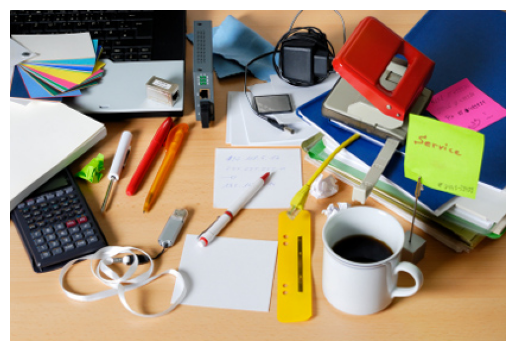

In [ ]:
image = Image.open(local_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Детектирование с помощью Grounding DINO

Для начала выполним полный цикл: попробуем найти объект на изображении и получить его маску сегментации. В качестве примера возьмём "кружку".

Первым шагом используем Grounding DINO — модель, которая по текстовому запросу находит соответствующий объект на изображении и возвращает его bounding box.



In [ ]:
TEXT_PROMPT = "cup"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=groundingdino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE
)

Посмотрим, что возвращает модель:

In [ ]:
print('boxes:\n', boxes)
print('\nlogits:\n', logits)
print('\nphrases:\n', phrases)

boxes:
 tensor([[0.7311, 0.7564, 0.2073, 0.3309]])

logits:
 tensor([0.7097])

phrases:
 ['cup']


Используем это, чтобы отобразить на изображении:

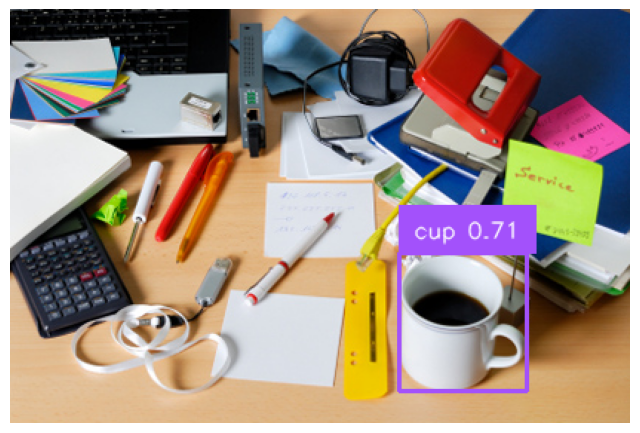

In [ ]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

Отлично! Модель нашла объект, теперь давайте сегментируем его.

# Сегментация с помощью SAM

Прежде чем передать найденные **bounding boxes** в модель **SAM**, нужно привести их к **нужному формату и масштабу**, потому что:

1. **Grounding DINO** возвращает координаты прямоугольников в формате `cx, cy, w, h` — то есть:
   - `cx`, `cy` — центр объекта,
   - `w`, `h` — ширина и высота рамки,
   - при этом **все координаты нормированы от 0 до 1** (относительно ширины и высоты изображения).

2. **SAM** ожидает прямоугольники в формате `x1, y1, x2, y2` (координаты углов рамки), выраженные в **пикселях**.

Реализуем это в коде:

In [ ]:
# box: normalized box xywh -> unnormalized xyxy
sam_predictor.set_image(image_source)
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [ ]:
print('boxes before:', boxes)
print('boxes after:', boxes_xyxy)

boxes before: tensor([[0.7311, 0.7564, 0.2073, 0.3309]])
boxes after: tensor([[262.2740, 164.8714, 348.9255, 257.1979]])


Теперь передадим их в модель:

In [ ]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes =transformed_boxes,
            multimask_output=False,
        )

Модель SAM умеет сегментировать объекты, если указать ей точку на объекте или рамку.

Мы используем рамки, поэтому `point_coords=None, point_labels=None.`


`multimask_output=False` - возвращает только одну маску. Если `True`, SAM возвращает несколько вариантов маски, обычно 3.

Посмотрим, что возвращает SAM:

In [ ]:
masks.shape

torch.Size([1, 1, 279, 418])

Отобразим маску на изображении, для этого напишем функцию:

In [ ]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

И визуализиурем результат:

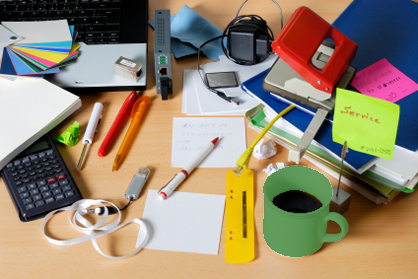

In [ ]:
annotated_frame_with_mask = show_mask(masks[0][0], image_source)
Image.fromarray(annotated_frame_with_mask)

Видно, как маска хорошо совпадает с искомым объектом. Можем отобразить только маску:

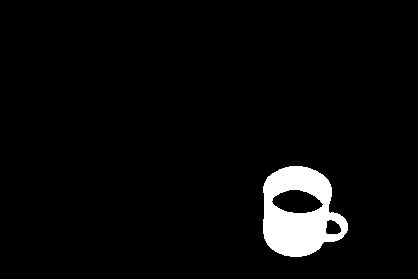

In [ ]:
image_mask = masks[0][0].cpu().numpy()
Image.fromarray(image_mask)

# Эксперименты

Проведем несколько экспериментов, для удобства демонстрации весь пайплайн разместим в одной функции:

In [ ]:
def get_results(
    TEXT_PROMPT="cup",
    BOX_TRESHOLD=0.3,
    TEXT_TRESHOLD=0.25,
    SAM=False
    ):

    image_source, image = load_image(local_image_path)

    boxes, logits, phrases = predict(
        model=groundingdino_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD,
        device=DEVICE
    )
    if not SAM:
        return boxes, logits, phrases

    sam_predictor.set_image(image_source)
    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
    masks, _, _ = sam_predictor.predict_torch(
                point_coords = None,
                point_labels = None,
                boxes = transformed_boxes,
                multimask_output = False,
            )

    return boxes, logits, phrases, masks

## Сегментируем другой объект

Протестируем, что все работает и сегментируем другой объект:

In [ ]:
boxes, logits, phrases, masks = get_results(TEXT_PROMPT="laptop",
                                            SAM=True)

Визуализируем маски:

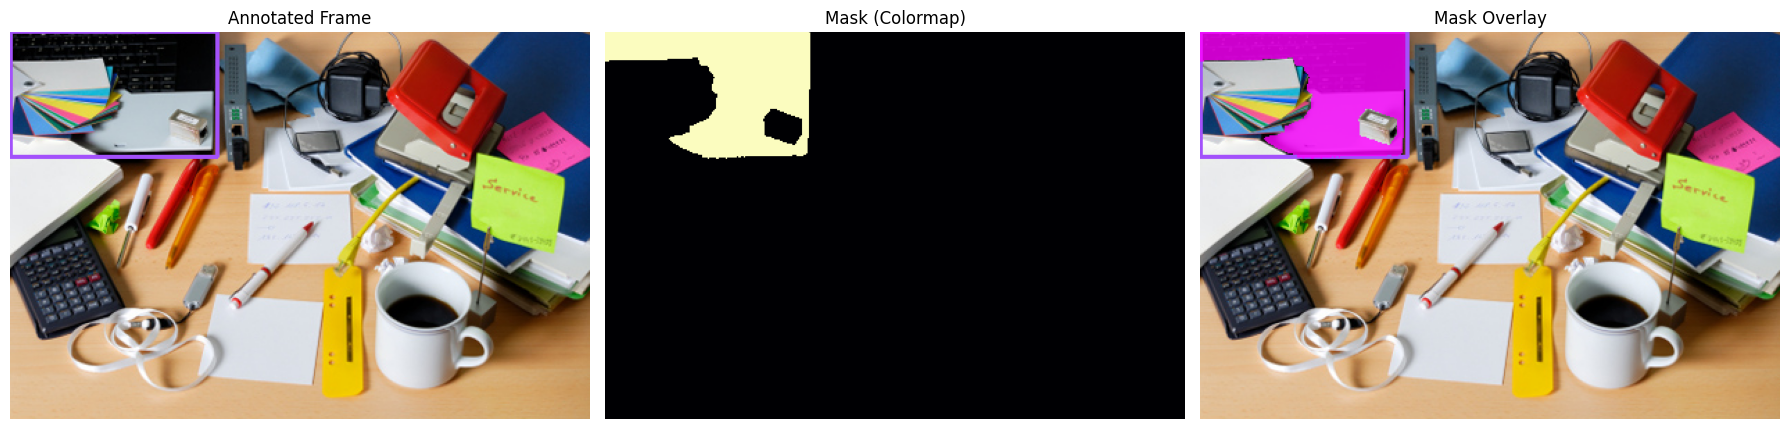

In [ ]:
annotated = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
mask = masks[0][0].cpu().numpy().astype(np.float32)
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
mask_norm = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)

color = np.zeros_like(annotated_rgb)
color[..., 0], color[..., 2] = 255, 255
overlay = annotated_rgb.copy()
idx = mask_norm > 0.5
overlay[idx] = (0.8 * color[idx] + 0.2 * overlay[idx]).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Annotated Frame", "Mask (Colormap)", "Mask Overlay"]
images = [annotated_rgb, mask, overlay]
cmaps = [None, 'magma', None]

for i in range(3):
    ax[i].imshow(images[i], cmap=cmaps[i])
    ax[i].set_title(titles[i])
    ax[i].axis("off")

plt.tight_layout()
plt.show()

Оттлично! Все работает

## Детектируем множество объектов

Давайте детектируем множество объектов. Например, видно что на столе несколько ручек, попробуем получить рамки для всех:

In [ ]:
boxes, logits, phrases = get_results(TEXT_PROMPT="pen",
                                            SAM=False)

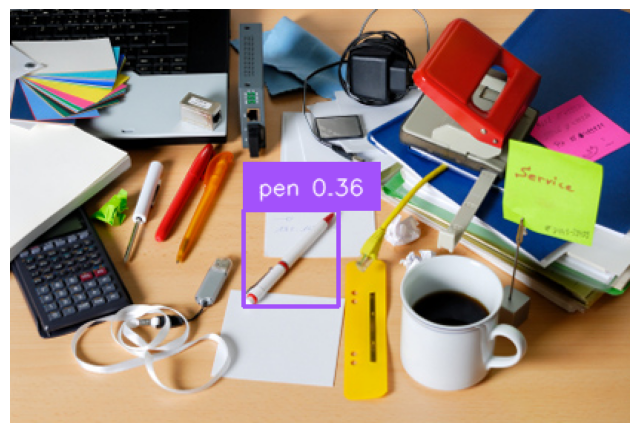

In [ ]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

У нас нашлась только одна, тут нам как раз понадобятся параметры `BOX_TRESHOLD` и `TEXT_TRESHOLD`


`BOX_TRESHOLD` это фильтр по "objectness score" — то есть насколько модель считает, что в этом месте вообще есть объект, неважно, какой.


`TEXT_TRESHOLD`	это то насколько объект в найденной рамке соответствует тексту

Попробуем понизить значения для нахождения рамок:

In [ ]:
boxes, logits, phrases = get_results(TEXT_PROMPT="pen",
                                            BOX_TRESHOLD=0.2,
                                            TEXT_TRESHOLD=0.25,
                                            SAM=False)

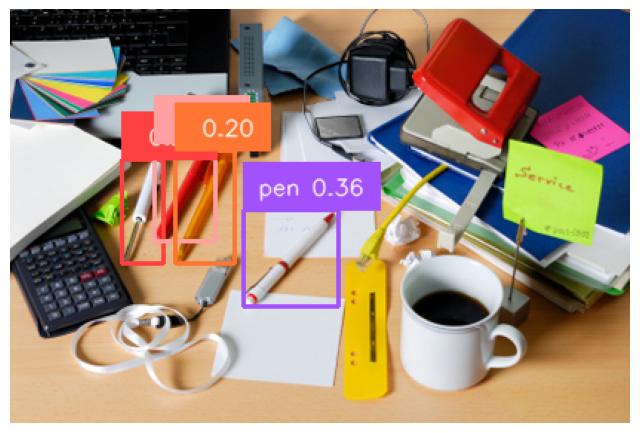

In [ ]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

Теперь все ручки нашлись

## Поиск объектов с уточнёнными признаками

Благодаря текстовому запросу мы можем формулировать более гибкие и точные условия поиска.
Например, вместо общего запроса "pen" можно указать "orange pen", и модель постарается найти только оранжевую ручку, игнорируя остальные.

In [ ]:
boxes, logits, phrases = get_results(TEXT_PROMPT="orange pen",
                                            SAM=False)

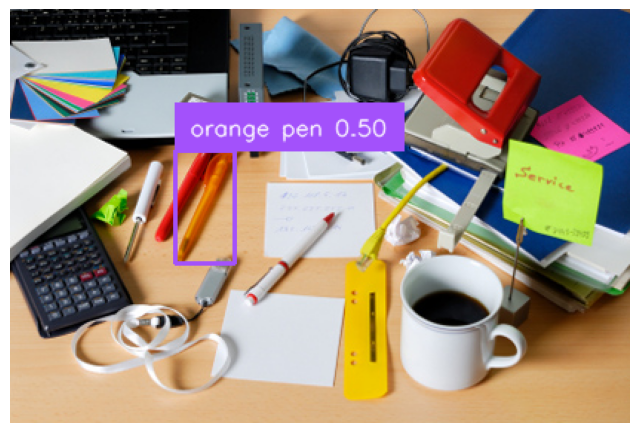

In [ ]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

Получилось, теперь найдем красную:

In [ ]:
boxes, logits, phrases = get_results(TEXT_PROMPT="red pen",
                                            SAM=False)

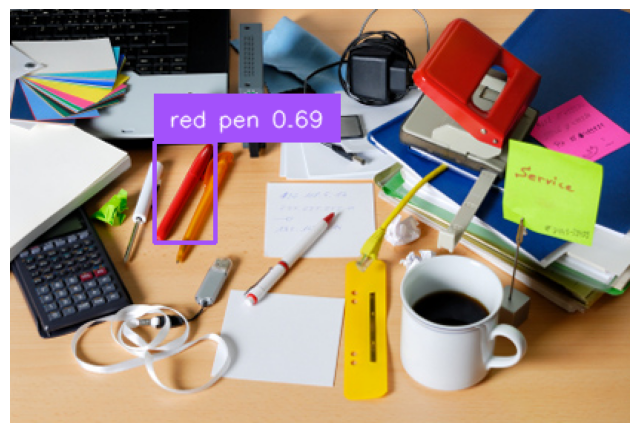

In [ ]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

Мы можем даже указывать расположение ручки, например найдем самую правую:

In [ ]:
boxes, logits, phrases = get_results(TEXT_PROMPT="pen most to the right",
                                            SAM=False)

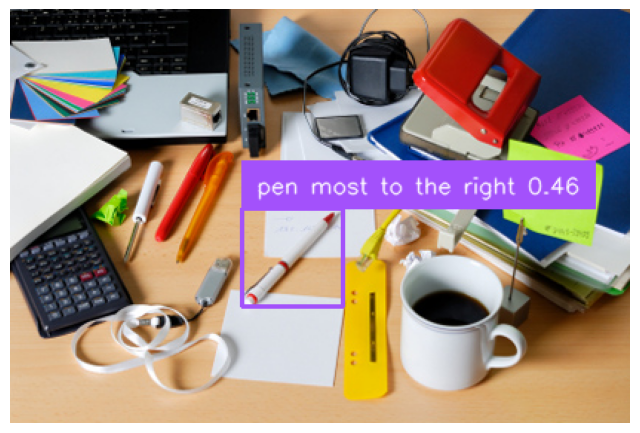

In [ ]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

## Несколько объектов для детекции в промте

Модель Grounding DINO позволяет использовать текстовые описания произвольной сложности. Кажется логичным передать сразу несколько объектов в одном промпте, например:
"calculator, laptop, cup, pen".

Попробуем это реализовать:

In [ ]:
boxes, logits, phrases = get_results(TEXT_PROMPT="calculator, laptop, cup, pen",
                                            SAM=False)

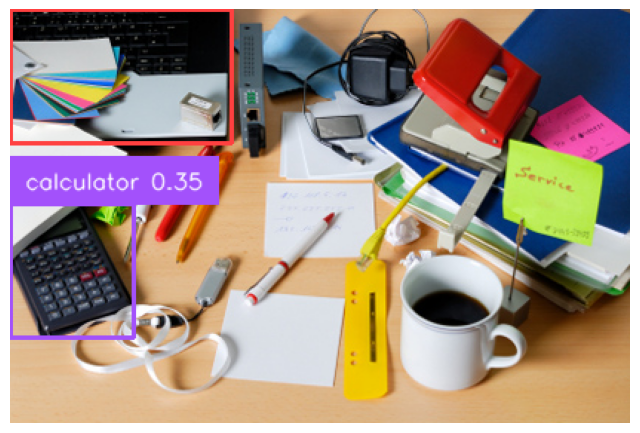

In [ ]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

Как мы видим, модель не обрабатывает этот список как четыре отдельных объекта. Вместо этого она воспринимает весь текст как одно описание, и пытается найти области, которые в целом соответствуют всей фразе.

На практике это означает, что часть объектов может быть пропущена, особенно если они "слабо представлены" в объединённом текстовом векторе.

Чтобы добиться максимальной точности, лучше запускать детекцию по одному объекту за раз.

В этом блокноте мы познакомились с современной связкой моделей **Grounding DINO** и **SAM**, которая позволяет выполнять **сегментацию объектов на изображении по текстовому описанию — без ручной разметки и без обучения на конкретном датасете**.

Мы разобрали:
- как Grounding DINO находит объекты по текстовому запросу (промпту) и возвращает bounding boxes;
- как SAM, получив эти рамки, создаёт **маски сегментации**;
- как интерпретировать параметры `BOX_THRESHOLD` и `TEXT_THRESHOLD` для управления точностью;
- и как с помощью текстовых запросов можно не только находить отдельные объекты, но и уточнять их свойства — например, цвет или положение.

Связка Grounding DINO + SAM — это пример того, как мощные **foundation-модели** можно комбинировать для решения сложных задач **прямо "из коробки"**, без дообучения и с минимальными усилиями.


# Дополнительные источники

[SAM Demo](https://segment-anything.com/demo) — демо модели SAM. Можно загрузить свои данные и быстро протестировать, чтобы понять сможет ли SAM хорошо отработать на ваших данных.

[Ноутбуки с применением roboflow](https://github.com/roboflow/notebooks) — набор различных руководств для компьютерного зрения.


[Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) — имплементация на PyTorch и предобученные модели для DINO.

[SAM](https://github.com/facebookresearch/segment-anything) — репозиторий модели SAM.
